This tries to partially reproduce the results from WDvS2013 paper.

However, we only use part of the data, and we use higher error tolerance so we don't expect to fully reproduce the result.

In [ ]:
import numpy as np
import pycyc
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl
from plotting import plot_intrinsic_vs_observed
import copy
import pickle

In [ ]:
from scipy.fft import rfft, fft, fftshift, ifft, fftn, ifftn

In [ ]:
# reload a module to incorporate code chanegs
import importlib
import sys
if "pycyc" in sys.modules.keys():
    importlib.reload(sys.modules["pycyc"])
import pycyc

In [ ]:
CS = pycyc.CyclicSolver("P2067/chan07/53873.27864.07.15s.cyc", zap_edges = 0.05556, pscrunch=True)
CS.data.shape, CS.nspec

In [ ]:
CS.load("P2067/chan07/53873.31676.07.15s.cyc")
CS.data.shape, CS.nspec

In [ ]:
CS.initProfile()

In [ ]:
plt.plot(CS.pp_int)

In [ ]:
pp_scattered = np.copy(CS.pp_ref)
pp_fft = np.log10(np.abs(rfft(pp_scattered)))
plt.plot(pp_fft[1:])

In [ ]:
filters = {}
intrinsic_profiles = {}

In [ ]:
# For first pass, either loop:

for isub in range(0, 80):
    CS.loop(isub=isub, make_plots=False, ipol=0, tolfact=10)
filters[0] = copy.deepcopy(CS.optimized_filters)
intrinsic_profiles[0] = copy.deepcopy(CS.intrinsic_profiles)

# or load up previous first pass:
# with open("filters_0.pkl", "rb") as fh:
#     filters[0] = pickle.load(fh)

# with open("profiles_0.pkl", "rb") as fh:
#     intrinsic_profiles[0] = pickle.load(fh)

In [ ]:
with open("filters_0.pkl", "wb") as fh:
    pickle.dump(filters[0], fh)

with open("profiles_0.pkl", "wb") as fh:
    pickle.dump(intrinsic_profiles[0], fh)

In [ ]:
# three more passes through 20 minutes (80 15 sec subints):
for ipass in range(1, 4):
    CS.pp_ref = np.copy(CS.pp_int)
    CS.pp_int = np.zeros((CS.nphase))
    for isub in range(0, 80):
        CS.loop(isub=isub, make_plots=False, ipol=0, tolfact=10, hf_prev=np.copy(filters[ipass-1][isub]))
    
    filters[ipass] = copy.deepcopy(CS.optimized_filters)
    intrinsic_profiles[ipass] = copy.deepcopy(CS.intrinsic_profiles)

In [ ]:
with open(f"filters_{ipass}.pkl", "wb") as fh:
    pickle.dump(filters[ipass], fh)

with open(f"profiles_{ipass}.pkl", "wb") as fh:
    pickle.dump(intrinsic_profiles[ipass], fh)

Now pass through all the data with intrinsic profile so far (output cleared)

In [ ]:
CS.pp_ref = np.copy(CS.pp_int)
CS.pp_int = np.zeros((CS.nphase))
for isub in range(0, CS.data.shape[0]):
    CS.loop(isub=isub, make_plots=False, ipol=0, tolfact=10)

In [ ]:
filters_full = {}
intrinsic_profiles_full = {}

In [ ]:
ipass = 0
filters_full[ipass] = copy.deepcopy(CS.optimized_filters)
intrinsic_profiles_full[ipass] = copy.deepcopy(CS.intrinsic_profiles)

In [ ]:
with open(f"filters_full_{ipass}.pkl", "wb") as fh:
    pickle.dump(filters_full[ipass], fh)

with open(f"profiles_full_{ipass}.pkl", "wb") as fh:
    pickle.dump(intrinsic_profiles_full[ipass], fh)

Reproduce Figure 2 of WDvS13

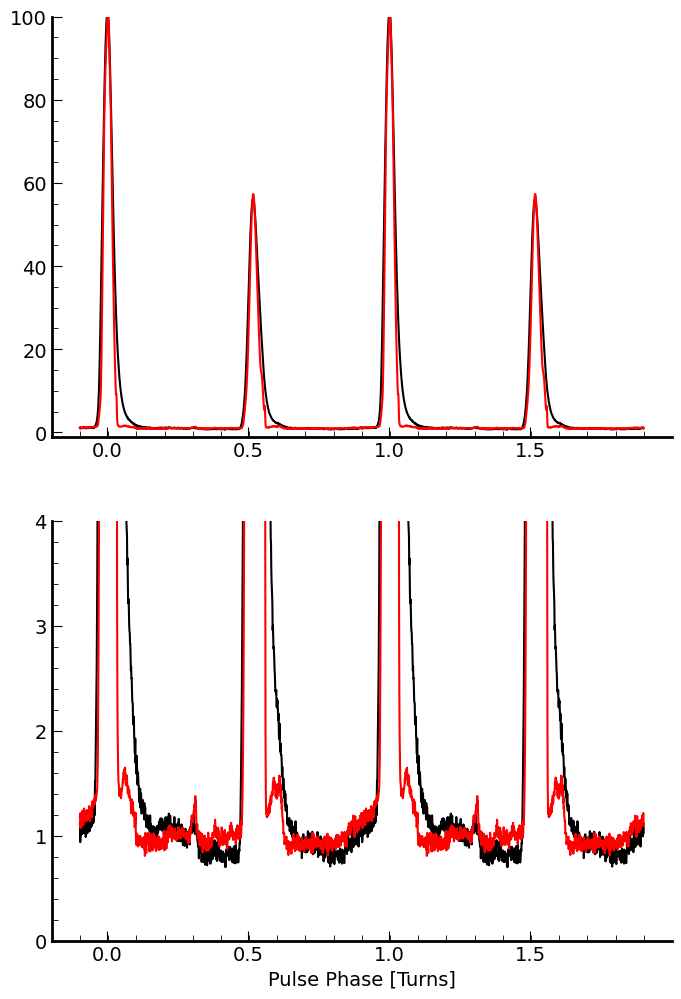

In [133]:
plot_intrinsic_vs_observed(CS, np.average(CS.data, axis=(0, 1, 2)))

Reproduce the bottom panel of Figure 7 of WDvS13

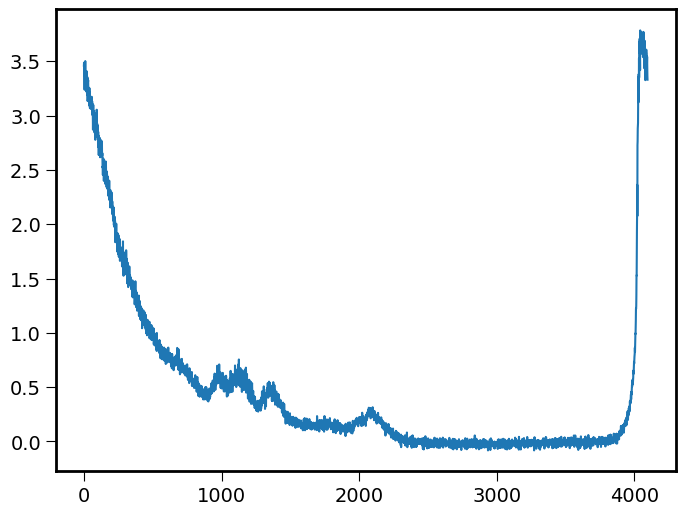

In [135]:
avg=np.sum(abs(ifft(filters_full[0],axis=1)),axis=0)
plt.plot(np.log(avg))

Reproduce Figure 8 of WDvS13, using the wavefield derived from only the second file (subint 236 onward)

In [136]:
subfilts=filters_full[0][236:]

Perform a backward FFT along the radio frequency to scattering delay axis, consistent with Equation 31 of WDvS13

In [137]:
subimp = ifft(subfilts, axis=1)

Perform a forward FFT along the time (sub-integration) to doppler shift axis, consistent with the usual time-to-frequency convention

In [138]:
wavefield = fft(subimp, axis=0)

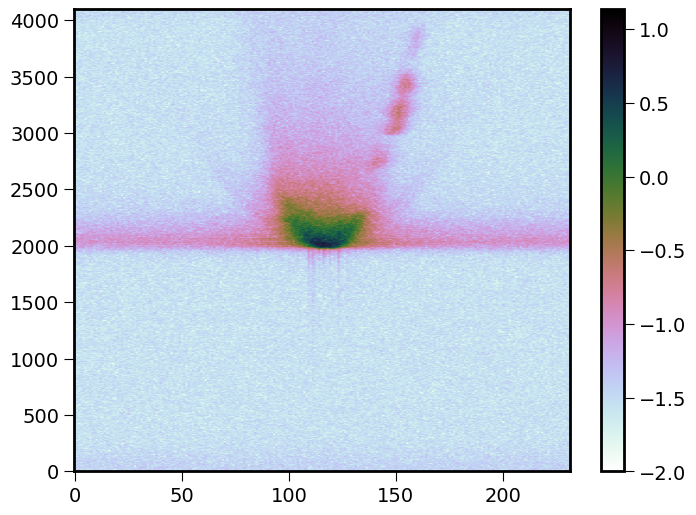

In [139]:
plotthis = np.log10(np.abs(fftshift(wavefield)))
plt.imshow(plotthis.T, aspect="auto", origin="lower", cmap="cubehelix_r", vmin=-2)
plt.colorbar()